# Deep Hedging AI
### Recurrent Network: impact of using recurrent networks on hedging forward started options

Hans Buehler, January 2023


In [1]:
""" Slighly annoying: by default the SageMaker Python import directory does not include our git directory """
#!pip -q install cdxbasics "tensorflow>=2.10" "tensorflow_probability==0.14"
import os
p = os.getcwd()
dhn = "/deephedging/"
i = p.find(dhn)
if i!=-1:
    p = p[:i]
    import sys
    sys.path.append(p)
    print("SageMaker: added python path %s" % p)

SageMaker: added python path /home/ec2-user/SageMaker


Deep Hedging AI says hello ... 

2023-01-24 18:44:58.470143: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-24 18:44:58.610415: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


Tensorflow version 2.10.0 running on 1 CPUs and 0 GPUs


2023-01-24 18:45:00.198573: E tensorflow/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-01-24 18:45:00.198614: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ip-172-16-12-144.eu-west-2.compute.internal): /proc/driver/nvidia/version does not exist
2023-01-24 18:45:00.992399: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


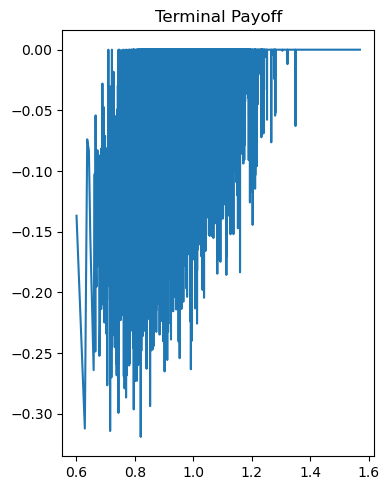

In [2]:
print("Deep Hedging AI says hello ... ", end='')
from cdxbasics.config import Config
from deephedging.trainer import train
from deephedging.gym import VanillaDeepHedgingGym
from deephedging.world import SimpleWorld_Spot_ATM
import numpy as np

from cdxbasics.dynaplot import figure
from IPython.display import display, Markdown

# see print of the config below for numerous options
config = Config()
# world

pcent = 0.2
put_strike = 1.0
lower_KO   = 1.-pcent
upper_KO   = 1.+pcent

def fwd_start( spots ):
    """ Short double KO put
    
        Parameters
        ----------
            spots : spots of the equity[None,nSteps]
            
        Returns
        -------
            Payoff [None]
    """
    l          = spots.shape[1]
    terminal   = np.maximum( put_strike * spots[:,l//2] - spots[:,-1], 0. )  # put
    return -terminal

config.world.samples = 20000
config.world.steps = 20
config.world.drift = 0.
config.world.black_scholes = True
config.world.payoff = fwd_start
# gym
config.gym.objective.utility = "cvar"
config.gym.objective.lmbda = 1.
config.gym.agent.network.depth = 5
config.gym.agent.network.activation = "softplus"
config.gym.agent.recurrence = 10 # recurrent nodes
# trainer
config.trainer.train.optimizer.name = "adam"
config.trainer.train.optimizer.learning_rate = 0.001
config.trainer.train.optimizer.clipvalue = 1.
config.trainer.train.optimizer.global_clipnorm = 1.
config.trainer.train.batch_size = config.world("samples")
config.trainer.train.epochs = 20000
config.trainer.caching.mode = "on"
config.trainer.caching.epoch_freq = 100
config.trainer.visual.epoch_refresh = 20
config.trainer.visual.confidence_pcnt_lo = 0.25
config.trainer.visual.confidence_pcnt_hi = 0.75
config_recurrent = config.copy()

# create world
world  = SimpleWorld_Spot_ATM( config.world )
val_world  = world.clone(samples=world.nSamples//2)

fig = figure()
ax  = fig.add_subplot()
ax.set_title("Terminal Payoff")
spotsT = world.details.spot_all[:,-1]
payoff = world.data.market.payoff
ixs    = np.argsort(spotsT)
spotsT = spotsT[ixs]
payoff = payoff[ixs]
ax.plot( spotsT,payoff )
fig.render()
fig.close()

## Hedging a barrier with recurrence

Gym with 2204 trainable weights compiled and initialized. Took 2s
Agent is using 2202 weights: 2191 for the main agent per step, 1 for initial delta, 10 for the initial state.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, recurrent_state, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price, recurrent_state and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
 Features available for initial state: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial state:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/5052f273543a9e25f68f24fb56c63a40.pck'
Cache successful

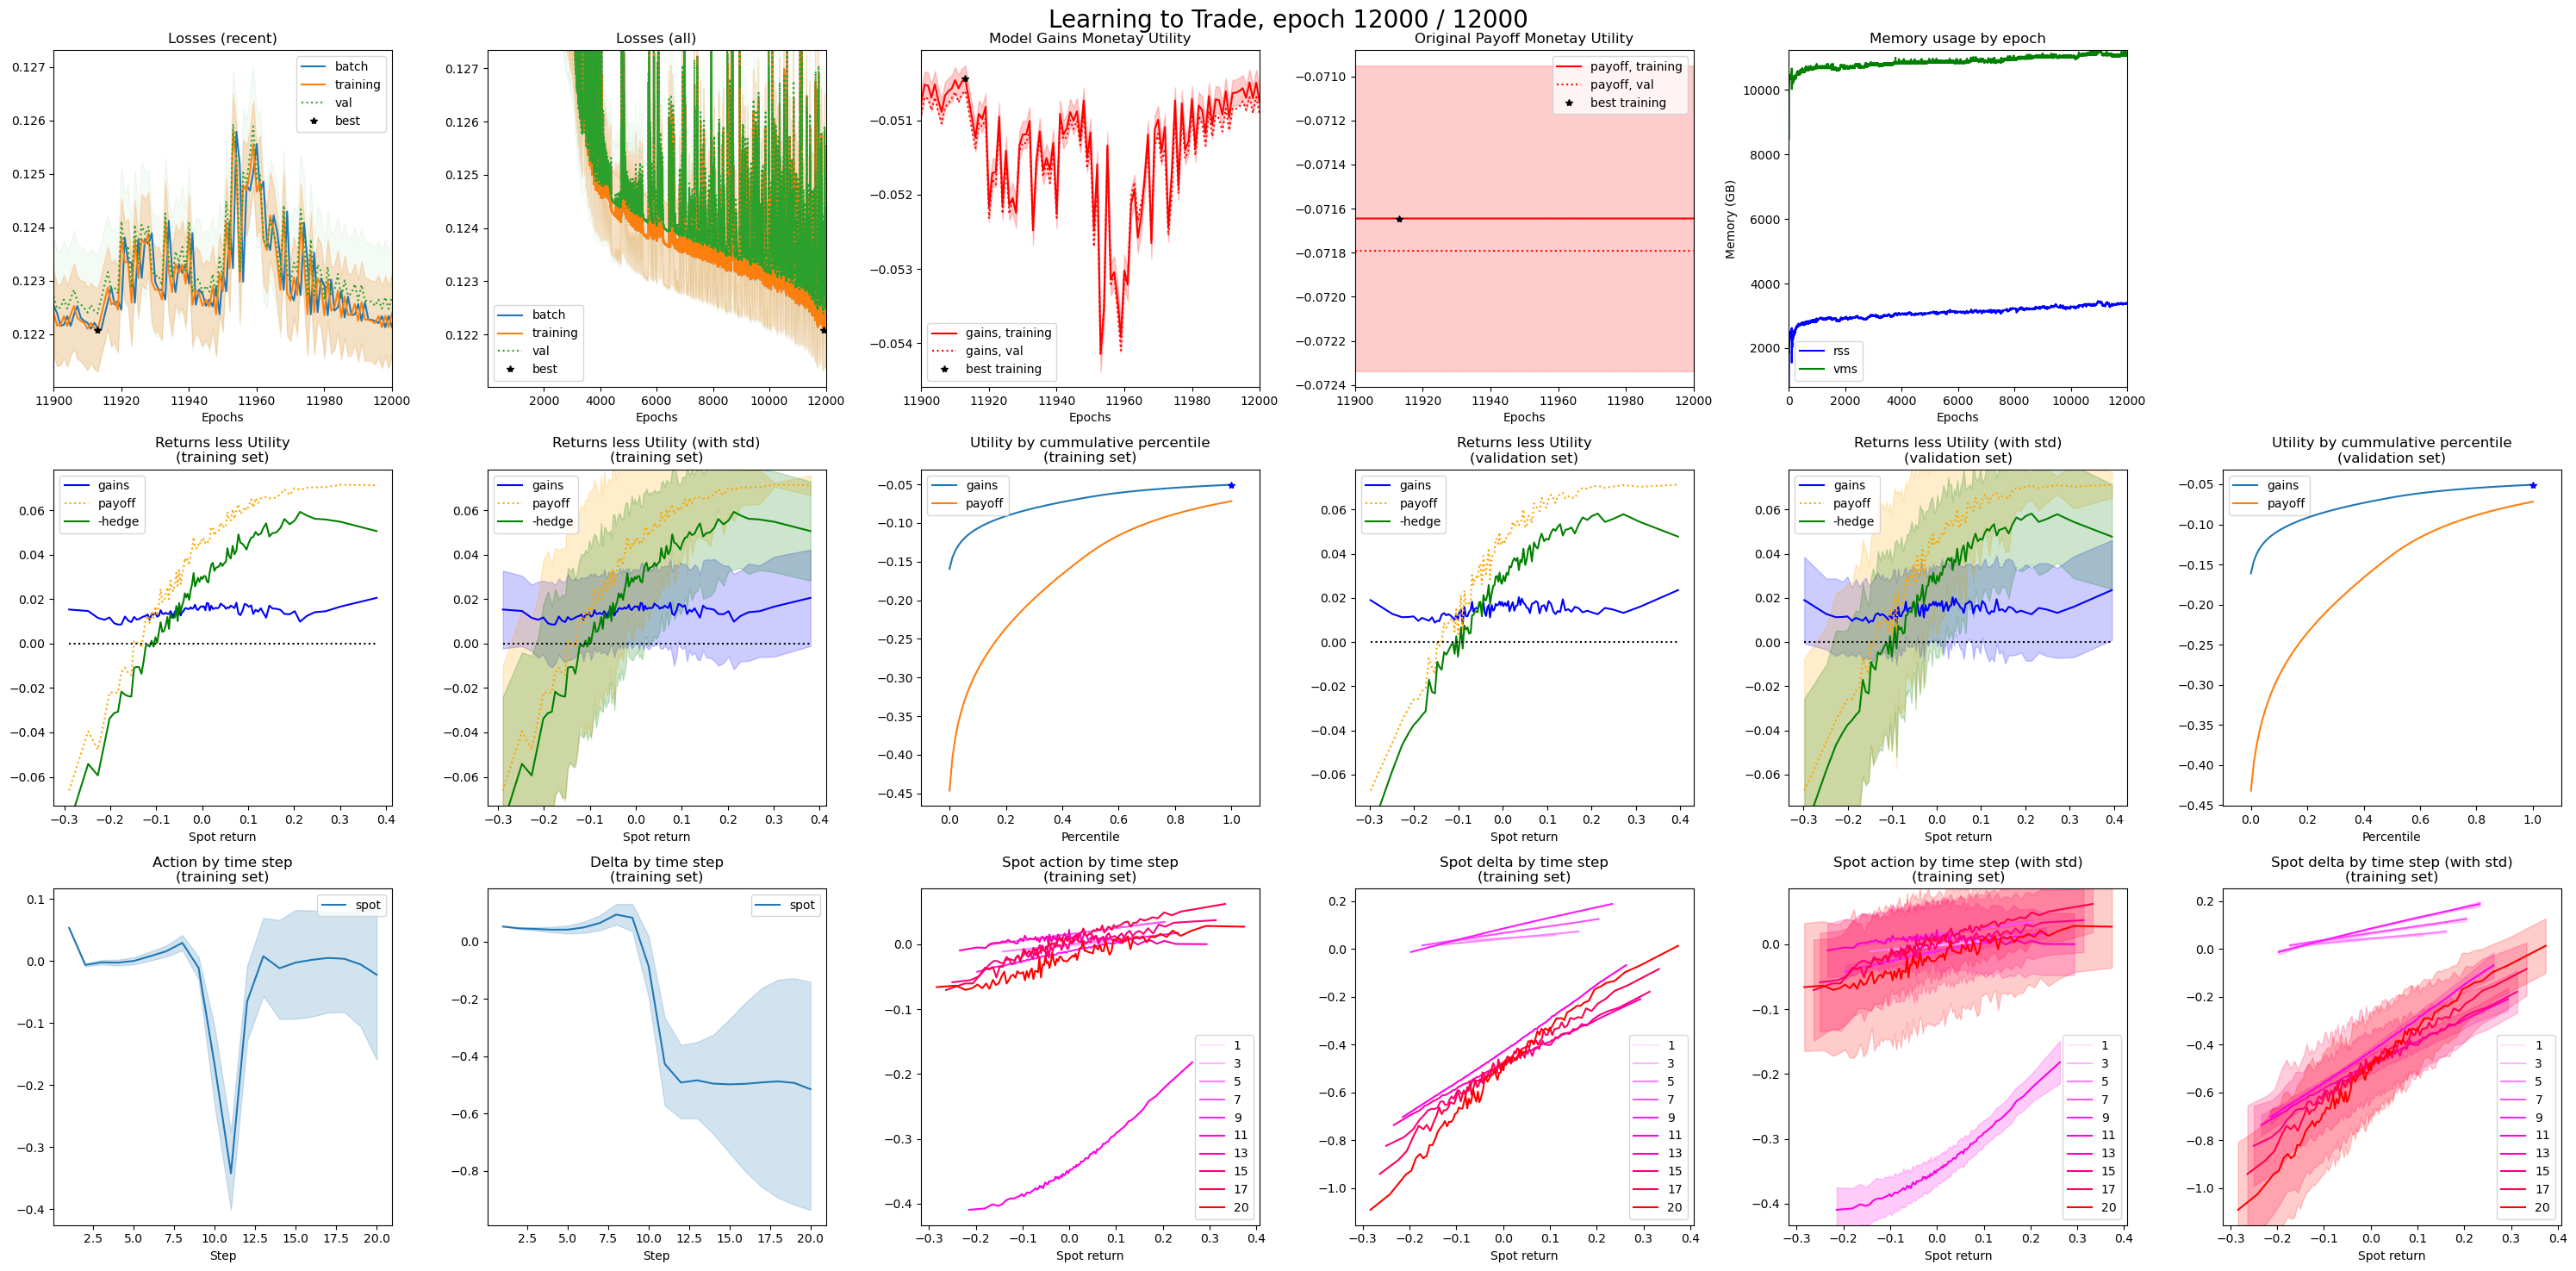

Training 12000/12000 epochs; 2204 weights; 20000 samples; 10000 validation samples batch size 20000 | initial loss 0.311741 (0.00238969), training 0.122395 (0.00076117), best 0.12208 (0.00238969), batch 0.122135, val 0.122711 (0.00107289). Best epoch 11913; last cached 12000. | memory used: rss 3377.52M, vms 11056.8M | time elapsed 30:55; time per epoch 0s; estimated time remaining 0s                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 11913
 State of training until epoch 12000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/5052f273543a9e25f68f24fb56c63a40.pck

Training terminated. Total time taken 6s


In [3]:
# create training environment
display(Markdown("## Hedging a barrier with recurrence"))
gym = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym, world=world, val_world=val_world, config=config.trainer )
config.done()

## Hedging a barrier without recurrence

Gym with 1784 trainable weights compiled and initialized. Took 0s
Agent is using 1782 weights: 1781 for the main agent per step, 1 for initial delta.
 Features available per time step:     action, cost, delta, ivol, lbnd_a, pnl, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used per time step:          delta, price and time_left
 Features available for initial delta: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used by initial delta:       -
Monetary utility cvar@1 is using 1 weight
 Features available: cost, ivol, lbnd_a, price, spot, sqrt_time_left, time_left and ubnd_a
 Features used:      -
Caching enabled @ '/home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/cfed8730f5f751c12c5478b2ac9ab30d.pck'
Cache successfully loaded. Current epoch: 12000
Nothing to do: cached model loaded from /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/cfed8730f5f751c12c5478b2ac9ab30d.pck was trained for 12000 epochs; you h

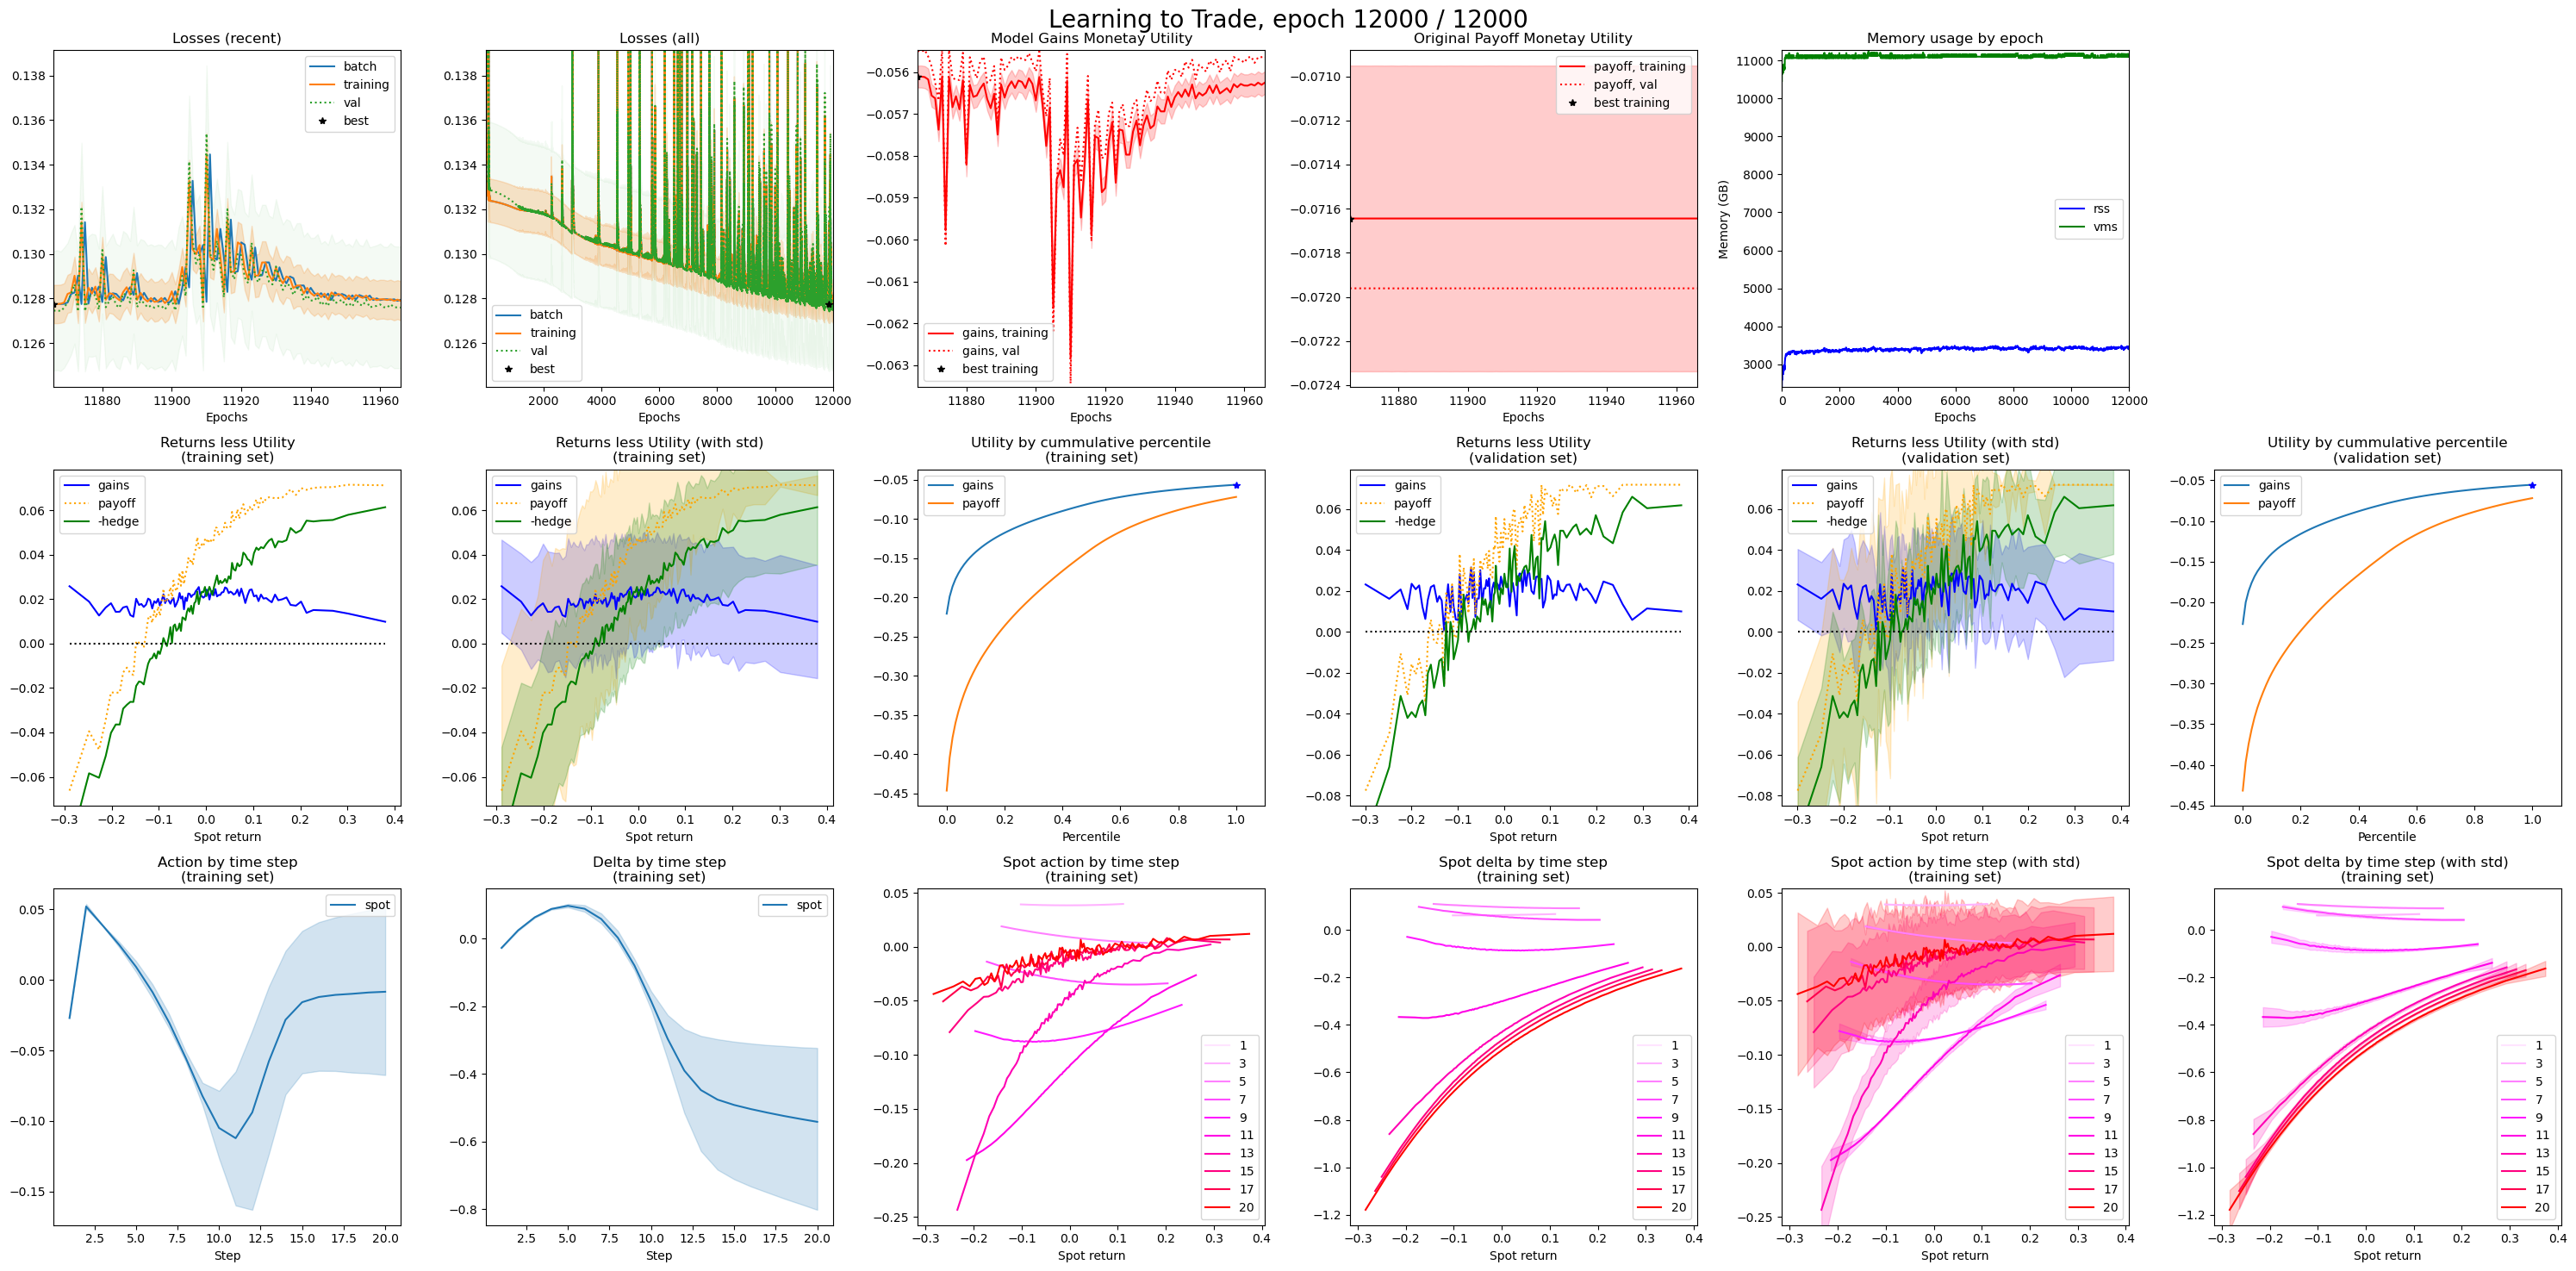

Training 12000/12000 epochs; 1784 weights; 20000 samples; 2000 validation samples batch size 20000 | initial loss 1.25275 (0.0128025), training 0.127757 (0.000861558), best 0.127748 (0.0128025), batch 0.12776, val 0.12745 (0.00269189). Best epoch 11866; last cached 12000. | memory used: rss 3454.88M, vms 11100.6M | time elapsed 28:57; time per epoch 0s; estimated time remaining 0s                        
 Status: Cached model already sufficiently trained.
 Weights set to best epoch: 11866
 State of training until epoch 12000 cached into /home/ec2-user/SageMaker/deephedging/notebooks/.deephedging_cache/cfed8730f5f751c12c5478b2ac9ab30d.pck

Training terminated. Total time taken 6s


In [4]:
config_recurrent.gym.agent.recurrence = 0 # recurrent nodes
config = config_recurrent

display(Markdown("## Hedging a barrier without recurrence"))

# create world
world2  = SimpleWorld_Spot_ATM( config.world )
val_world2  = world.clone(samples=world.nSamples//10)

# create training environment
gym2 = VanillaDeepHedgingGym( config.gym )

# create training environment
train( gym=gym2, world=world2, val_world=val_world2, config=config.trainer )
config.done()

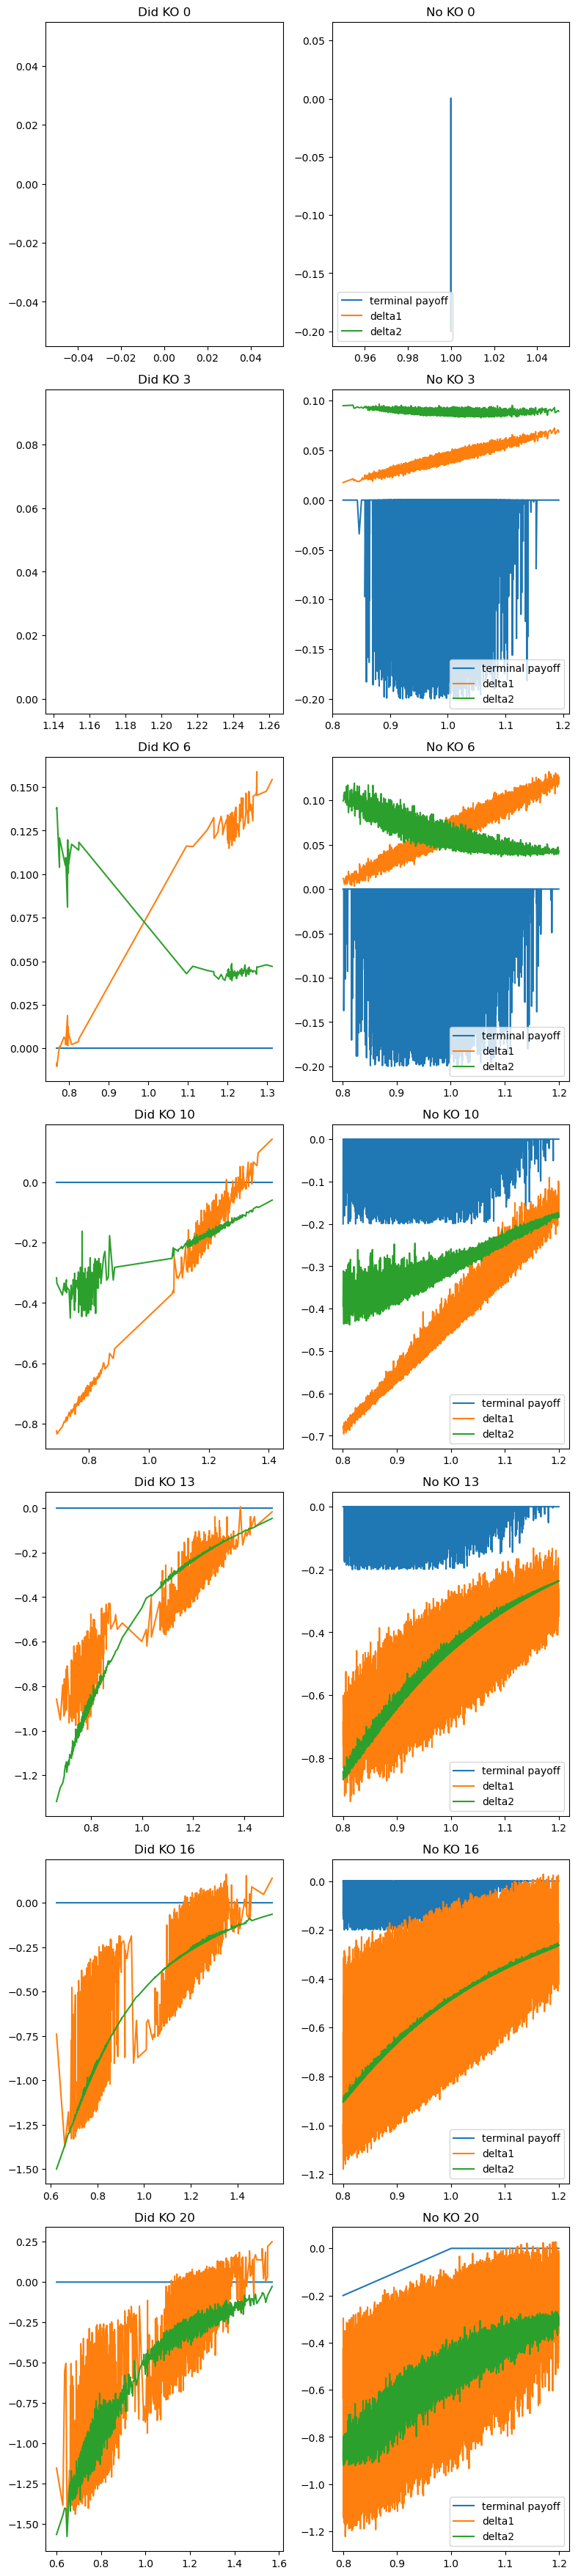

In [5]:
payoff = world.data.market.payoff

from deephedging.base import npCast
from cdxbasics.dynaplot import figure
fig = figure()

r1 = npCast( gym(world.tf_data) )
r2 = npCast( gym2(world2.tf_data) )

nSteps = world.nSteps
spots  = world.details.spot_all
payoff = world.data.market.payoff
nBinSteps = 7
ixs    = np.linspace(0,nSteps,nBinSteps,endpoint=True,dtype=np.int32)

pcent = 0.2
put_strike = 1.0
lower_KO   = 1.-pcent
upper_KO   = 1.+pcent

actions1   = r1['actions'][:,:,0]
actions2   = r2['actions'][:,:,0]
deltas1    = np.cumsum(actions1, axis=1)
deltas2    = np.cumsum(actions2, axis=1)

def barrier_option( spots ):
    """ Short double KO put
    
        Parameters
        ----------
            spots : spots of the equity[None,nSteps]
            
        Returns
        -------
            Payoff [None]
    """
    terminal   = np.maximum( put_strike - spots[:,-1], 0. )  # put
    lower      = np.where( np.min( spots, axis=1 ) >= lower_KO, 1., 0. )
    upper      = np.where( np.max( spots, axis=1 ) <= upper_KO, 1., 0. )
    return -terminal*lower*upper

payoff2 = barrier_option( spots )

errors = []

for i in ixs:
    ax_ko = fig.add_subplot()
    ax_pay = fig.add_subplot()
    ax_ko.set_title("Did KO %ld" % i)
    ax_pay.set_title("No KO %ld" % i)
    fig.next_row()

    spots_t  = spots[:,i]
    ixs      = np.argsort( spots_t )
    spots_t  = spots_t[ixs]
    spots_0t = spots[ixs,:i+1]
    payoff_t = payoff2[ixs]
    delta1_t = deltas1[ixs,min(i,nSteps-1)]
    delta2_t = deltas2[ixs,min(i,nSteps-1)]
    no_loko  = np.min( spots_0t, axis=1 ) >= lower_KO
    no_upko  = np.max( spots_0t, axis=1 ) <= upper_KO
    no_ko    = no_loko * no_upko
    ko       = np.logical_not(no_ko)
    c        = float(i)/float(nSteps)
    
    ax_ko.plot( spots_t[ko], payoff_t[ko], label="terminal payoff")
    ax_ko.plot( spots_t[ko], delta1_t[ko], label="delta1")
    ax_ko.plot( spots_t[ko], delta2_t[ko], label="delta2")

    ax_pay.plot( spots_t[no_ko], payoff_t[no_ko], label="terminal payoff")
    ax_pay.plot( spots_t[no_ko], delta1_t[no_ko], label="delta1")
    ax_pay.plot( spots_t[no_ko], delta2_t[no_ko], label="delta2")

    ax_pay.legend()
    
fig.close()


spots_t   = spots_t[ko]
payoff_ko = payoff[ko]

for e in errors:
    print(e[0])
    print("  spots", e[1])
    print("  values", e[2])


In [6]:
!True

/bin/sh: True: command not found


In [7]:
x = np.zeros((2,3))
x[0,:] = [4,3.,2.]
x[1,:] = -1.

np.min(x,axis=1)

array([ 2., -1.])

In [8]:
import numpy as np
import math
x = np.linspace(-2,2,101)
y = np.cos(x)
p = x*0. + 1./float(len(x))

i1 = 20
i2 = 30

mean = np.sum( (p*x)[i1:i2] )
var  = np.sum( (p*x*x)[i1:i2] ) - mean*mean
std  = math.sqrt( var - mean )
print(std)

0.4417102337449741
